In [1]:
import numpy as np
import tenpy
import tenpy.linalg.np_conserved as npc
import tenpy.models.spins
from tenpy.networks.mps import MPS
import tenpy.networks.site as site
from tenpy.algorithms import tdvp
import time
import matplotlib.pyplot as plt
from tenpy.algorithms import dmrg
import math
from scipy import fftpack, linalg, fft

In [2]:
def compute_spectrum(obs, N_t, delta_t, omega_ls, lambda_ls, tau):
    a = 0
    Gomega = np.empty(shape = (omega_ls.shape[0],lambda_ls.shape[0]), dtype = np.complex64)
    for i in range(omega_ls.shape[0]):
        for j in range(lambda_ls.shape[0]):
            omega = omega_ls[i]
            wave = lambda_ls[j]
            tmp = 0.0+0.0j
            for k in range(N_t):
                for l in range(L):
                    t = k*delta_t
                    tmp = tmp + math.exp(-(a*j*delta_t*t)**2/4)*obs[k,l]*np.exp(1.0j*(omega*tau*t-wave*l))*delta_t/(2*math.sqrt(np.pi))
            Gomega[i,j] = np.abs(tmp)
    return Gomega

def max_k_error(x,y):
    if x.size == y.size:
        mean_error = []
        L = int(x.shape[1])
        for k in range(L):
            mean_error.append(np.abs(x[:,k]-y[:,k]).sum()/x.shape[0])
        return np.max(mean_error)
    else:
        raise AttributeError("Matrices have differente sizes")

In [3]:
# We are defining the parameters for the Hamiltonian and time evolutio
spin = tenpy.networks.site.SpinHalfSite(conserve=None)
L = 51 #number of spins
chi = 16 #bound dimension
tau = 10
delta_t = 0.01
N_t = 100
J = 1.0
h = 0
model_params = {
    'L': L,
    'S': 0.5, #spin
    'conserve': None,
    'Jz':4*J,
    'Jy': 4*J,
    'Jx': 4*J,
    'hx': 0.0,
    'hy': 0.0,
    'hz': -2*h,
    'muJ': 0.0,
    'bc_MPS': 'finite', #boundary conditions
}

In [21]:
# INTIAL STATE: PLUS STATE PRODUCT STATE
heisenberg = tenpy.models.spins.SpinChain(model_params) #build hamiltonian
product_state = ["up"] * L  #we first build the intial product state
#build the local quench perturbed spin
for i in range(L):
  if i == L//2:
    #product_state[i] = 1/2*np.array([1+1.0j,1-1.0j])
    product_state[i] = np.array([0,1])
  else:
    product_state[i] = 1/math.sqrt(2)*np.array([1,1])

psi = MPS.from_product_state(heisenberg.lat.mps_sites(), product_state, bc=heisenberg.lat.bc_MPS, dtype=complex, form='B')

In [22]:
tdvp_params = { #tdvp parameters
            'start_time': 0,
            'dt': delta_t*tau,
            #'reortho': True,
            #'N_cache':  3,
            'trunc_params': {
                'chi_max': chi,
                'svd_min': 1.e-10,
                'trunc_cut': None
            }
        }
psi_tdvp = psi.copy()
tdvp_engine = tdvp.TDVPEngine(psi_tdvp, heisenberg, tdvp_params)
times = []
obs_tdvp = np.empty(shape = (N_t,L), dtype = np.complex64)
for i in range(N_t):
    n_j  = []
    tdvp_engine.run_two_sites(N_steps=1)
    times.append(tdvp_engine.evolved_time)
    for j in range(L):
        n_j = np.append(n_j, psi_tdvp.expectation_value('Sy', j))
    obs_tdvp[i] = n_j

krange = np.linspace(-np.pi,np.pi,L)
omega_ls = np.linspace(-15, 15,2*N_t-1)
matrix_tdvp = np.abs(compute_spectrum(obs_tdvp, N_t, delta_t, omega_ls, krange, tau))

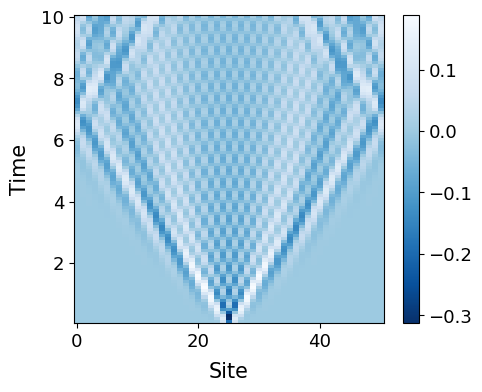

In [23]:
L_ls = range(L)
fig = plt.figure(figsize=(5,4))
axs = fig.add_subplot(1,1,1)
im = axs.pcolormesh(L_ls,  times, np.real(obs_tdvp))
im.set_cmap('Blues_r')
cbar = fig.colorbar(im, ax=axs, )
cbar.ax.tick_params(labelsize=13)
axs.xaxis.set_tick_params(labelsize=13)
axs.yaxis.set_tick_params(labelsize=13)
axs.set_xlabel('Site', fontsize=15, labelpad=8)
axs.set_ylabel('Time', fontsize=15, labelpad=8)
plt.savefig('heis_L_51_tau_5_time.png',bbox_inches='tight', dpi=1200)

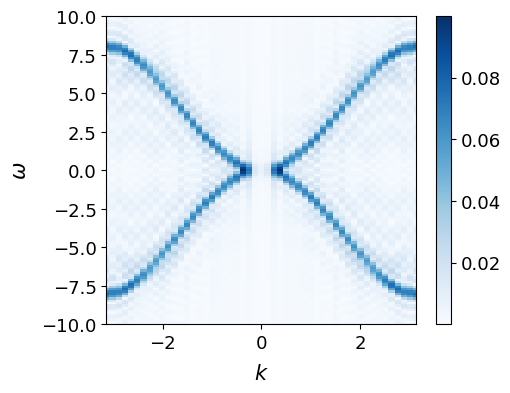

In [25]:
fig = plt.figure(figsize=(5,4))
axs = fig.add_subplot(1,1,1)
im = axs.pcolormesh(krange,  omega_ls, np.abs(matrix_tdvp))
im.set_cmap('Blues')
cbar = fig.colorbar(im, ax=axs,)
cbar.ax.tick_params(labelsize=13)
axs.xaxis.set_tick_params(labelsize=13)
axs.yaxis.set_tick_params(labelsize=13)
axs.set_xlabel(r'$k$', fontsize=15, labelpad=8)
axs.set_ylabel(r'$\omega$', fontsize=15, labelpad=8)
# for axis in ['top','bottom','left','right']:
#     axs.spines[axis].set_linewidth(1.3)
plt.xlim(-np.pi, np.pi)
plt.ylim(-10, 10)
# plt.yticks(np.arange(-10, 12, 4))
# plt.xticks(np.arange(-3, 4, 1))
plt.savefig('heis_L_51_tau_5_freq.png',bbox_inches='tight', dpi=1200)

In [ ]:
L_ls = [7,11,15,21,31,51]
tau_ls = [2,4,6,8,10]
error_w = np.load('max_k_error_heis_51.npy')

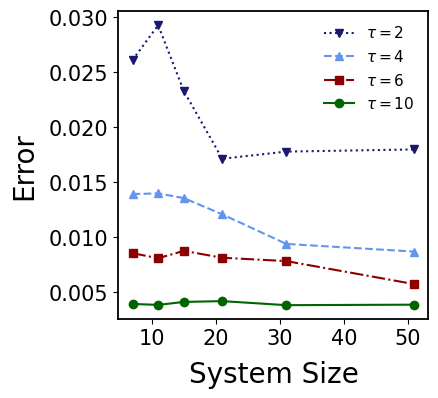

In [15]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)


ax.plot(L_ls, error_w[:,0], "v:", color = 'midnightblue', label = rf"$\tau={int(tau_ls[0])}$", lw=1.5)
ax.plot(L_ls, error_w[:,1], "^--", color = 'cornflowerblue', label = rf"$\tau={int(tau_ls[1])}$", lw=1.5)
ax.plot(L_ls, error_w[:,2], "s-.", color = 'darkred', label = rf"$\tau={int(tau_ls[2])}$", lw=1.5)
ax.plot(L_ls, error_w[:,4], "o-", color = 'darkgreen', label = rf"$\tau={int(tau_ls[4])}$", lw=1.5)

ax.set_xlabel('System Size', fontsize=20, labelpad=8)
ax.set_ylabel('Error', fontsize=20, labelpad=8)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.3)

plt.locator_params(axis='x', nbins=5)
ax.legend(fontsize=11, loc = 'upper right', frameon=False)
# fig.savefig('max_k_error2.png', bbox_inches='tight',dpi=1200)